# Prac 04

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

(<matplotlib.image.AxesImage at 0x14bbd5cd0>,
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)))

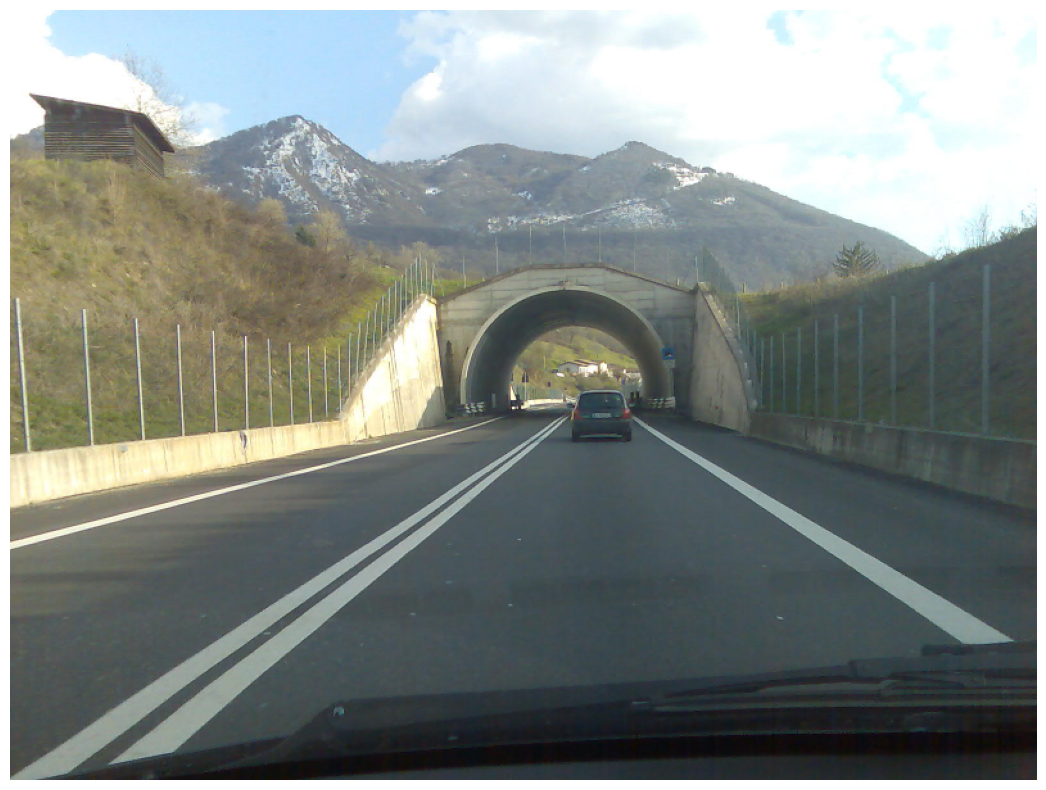

In [3]:
img = cv2.imread('../roadway.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img), plt.axis('off')

In [10]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [9]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
th_low = 100
th_high = 150
edges = cv2.Canny(gray, th_low, th_high)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)))

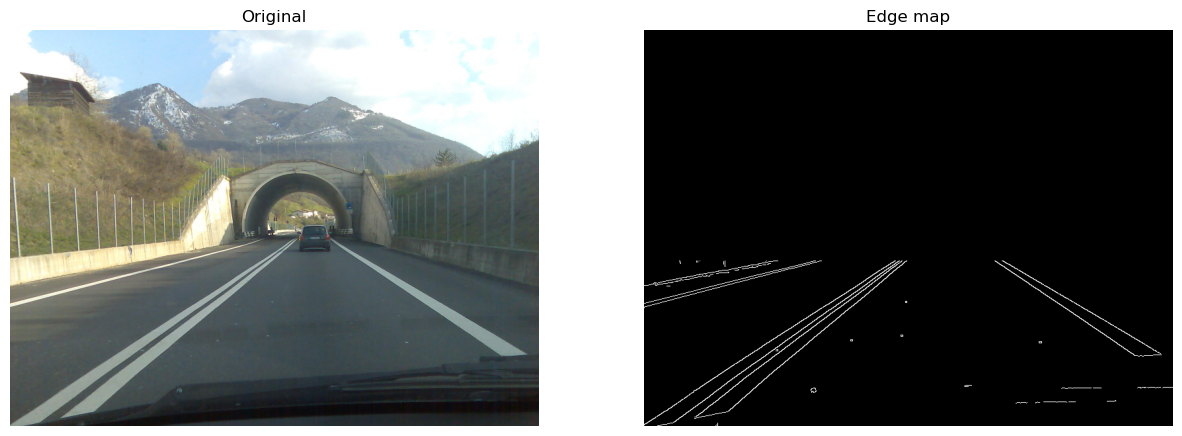

In [35]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original'), plt.axis('off')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map'), plt.axis('off')

In [22]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
rho = 2 
theta = np.deg2rad(2)  
threshold = 190 
 
lines = cv2.HoughLines(edges, rho, theta, threshold)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)))

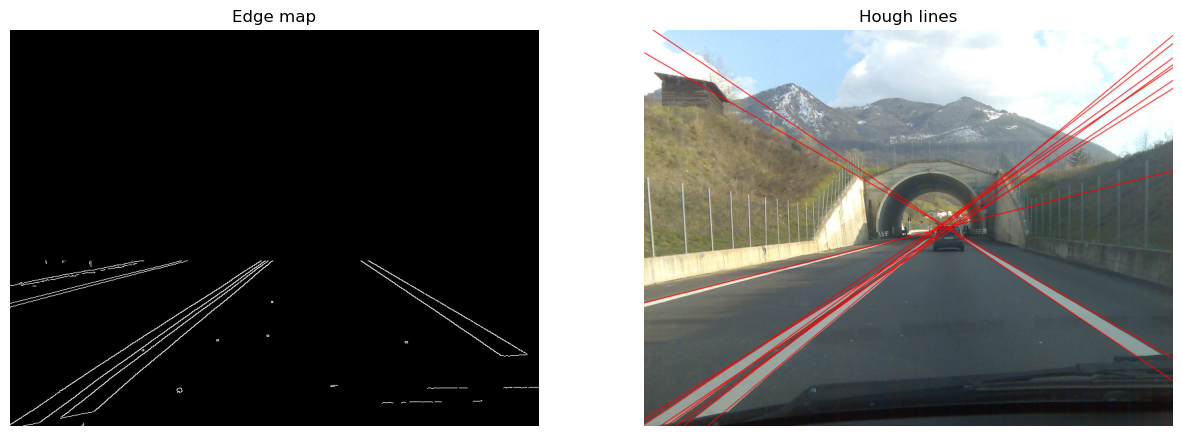

In [36]:
# Plot the resulting Hough lines
result = np.copy(img)

for line in lines:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map'), plt.axis('off')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines'), plt.axis('off')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [29]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees).
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    rho = line[0]
    theta = line[1]  
    
    # Keep line if theta is not horizontal
    lower_bound = np.deg2rad(70)  
    upper_bound = np.deg2rad(110) 
    
    if not (lower_bound <= theta <= upper_bound):
        filtered_lines.append(line)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)))

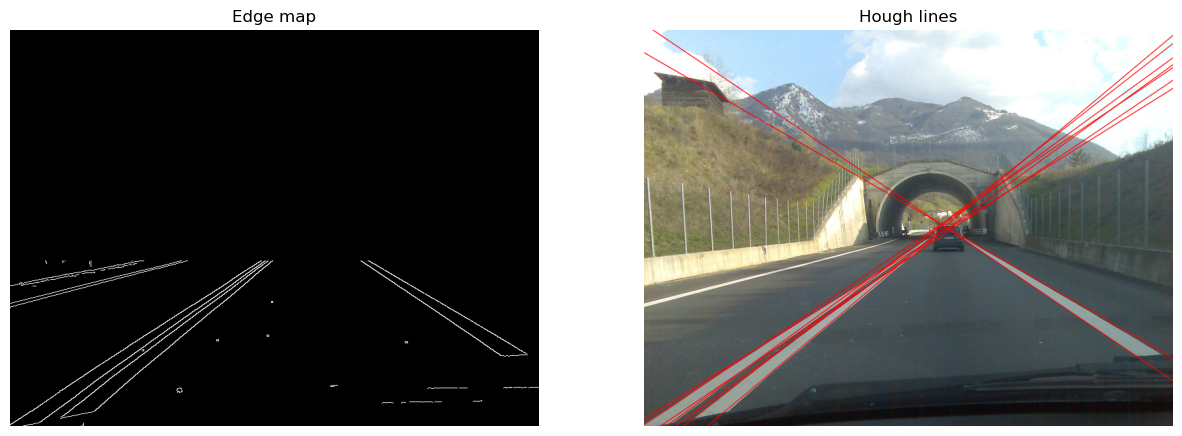

In [37]:
# Let's plot the resulting filtered lines
result = np.copy(img)

for line in filtered_lines:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    cv2.line(result, pt1, pt2, (255, 0, 0), 1, cv2.LINE_AA)  

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map'), plt.axis('off')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines'), plt.axis('off')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [32]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[507.        ,   0.92502448],
       [ 31.        ,   2.09439516],
       [ -7.        ,   2.16420817],
       [497.        ,   0.99483767],
       [521.        ,   0.87266463],
       [512.        ,   0.95993108]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)))

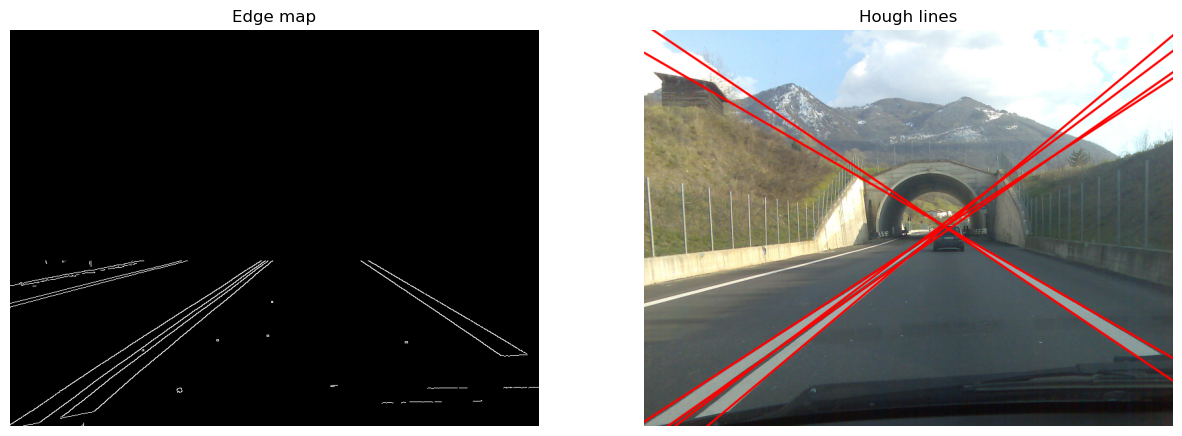

In [38]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)

for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    cv2.line(result, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA) 

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map'), plt.axis('off')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines'), plt.axis('off')

### Questions
* Do you see anything strange in the final result? - lines on the top
* Do you think the Hough transform resolution is important for obtaining a good result? Why? It affects the accuracy and precision of line detection
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why? - It determines the minimum number of intersecting points required in the accumulator space to recognize a line